In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt

%matplotlib inline

In [4]:
# reading data and assigning to a pandas dataframe
# name, redshift, distance module, distance module error
column_names = ['name', 'z', 'dm', 'dm_err']
udf = pd.read_csv('SCPUnion2.1_mu_vs_z.txt',sep ='\t', skiprows=5,header=None,usecols=[0,1,2,3],
                      names = column_names, index_col = 0)
udf.sort_values('z', inplace=True)
udf[:5]

,z,dm,dm_err
name,,,
1999aa,0.015000,34.163504,0.161453
2007s,0.015000,34.111411,0.213389
2006td,0.015000,34.379773,0.217349
2005bo,0.015027,33.950192,0.178117
2007ca,0.015100,34.525875,0.213682


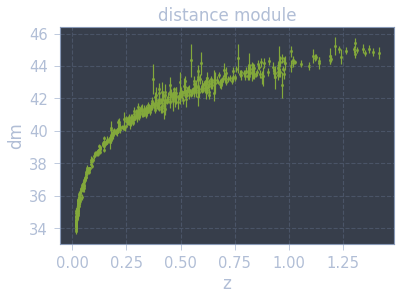

In [5]:
# distance modulus as a function of redshift with error bars
udf.plot.scatter(x='z',y='dm',yerr='dm_err', c='C1',s=8);
plt.title('distance module');

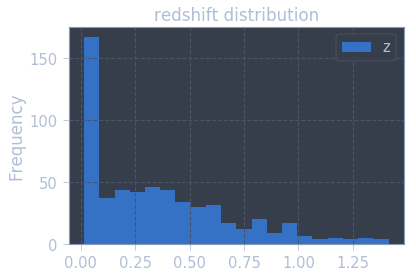

In [6]:
# redshift distribution
udf.plot.hist(y='z',bins=20);
plt.title('redshift distribution');

luminosity distance:
$$d_L = 10^{\, \mu/5 + 1}$$
$$\delta d_L = 2\cdot 10^{\mu/5}\log 10 \delta\mu $$


In [7]:
dl = 10**(udf.dm/5+1)
dl_err = 2 * 10**(udf.dm/5) * np.log(10) * udf.dm_err
udf['dl'],udf['dl_err'] = dl,dl_err

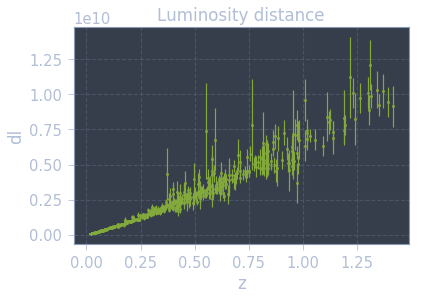

In [7]:
udf.plot.scatter(x='z',y='dl',yerr='dl_err',c='C1',s=8);
plt.title('Luminosity distance');

In [93]:
x = udf.z.values


In [112]:
# curve fit function
def cfit(f):
    x, y, y_err = udf[['z','dl','dl_err']].values.T
    popt, pcov = opt.curve_fit(f, x, y, sigma=y_err)
    chi2 = np.sum((f(x,*popt) - y)**2/y_err**2)
    return popt, pcov, chi2

# curve fit plot
def cf_plot(f , label=None):
    popt, pcov, chi2 = cfit(f)
    plt.plot(udf.z,f(udf.z, *popt), lw=2, 
             label=label+": chi2={}".format(np.round(chi2/len(udf),decimals=2)))

# fitting functions
def p2(x,c0,c1,c2):
    return c0 + c1*x + c2*x**2

def p3(x,c0,c1,c2,c3):
    return c0 + c1*x + c2*x**2 + c3*x**3

def e1(x, c0, c1, c2):
    return c0 + c1*np.exp(c2*x)

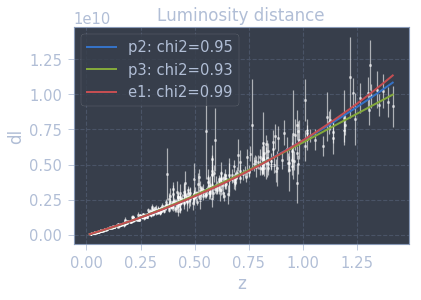

In [113]:
udf.plot.scatter(x='z',y='dl',yerr='dl_err',c='white',alpha=0.6,s=8);
plt.title('Luminosity distance');

cf_plot(p2, 'p2')
cf_plot(p3, 'p3')
cf_plot(e1, 'e1')

plt.legend()
plt.show()